<a href="https://colab.research.google.com/github/Meyiwa123/LIDAR-Grid-Visualizer/blob/main/visualizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import math
import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin, radians, pi
from collections import deque
from google.colab import files

In [ ]:
# Read LIDAR laser beams (angles and corresponding distance data) from a CSV file
def file_read():
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    measures = [line.split(",") for line in uploaded[filename].decode().split("\n")]
    angles = []
    distances = []
    for measure in measures:
        if len(measure) == 2:
            try:
                angles.append(float(measure[0]))
                distances.append(float(measure[1]))
            except ValueError:
                pass  # Skip invalid data
    angles = np.array(angles)
    distances = np.array(distances)
    return angles, distances

# Load LIDAR data from the uploaded CSV file
ang, dist = file_read()

# Convert LIDAR measurements to Cartesian coordinates (x, y)
ox = np.sin(ang) * dist
oy = np.cos(ang) * dist

Saving lidar_data.csv to lidar_data (13).csv


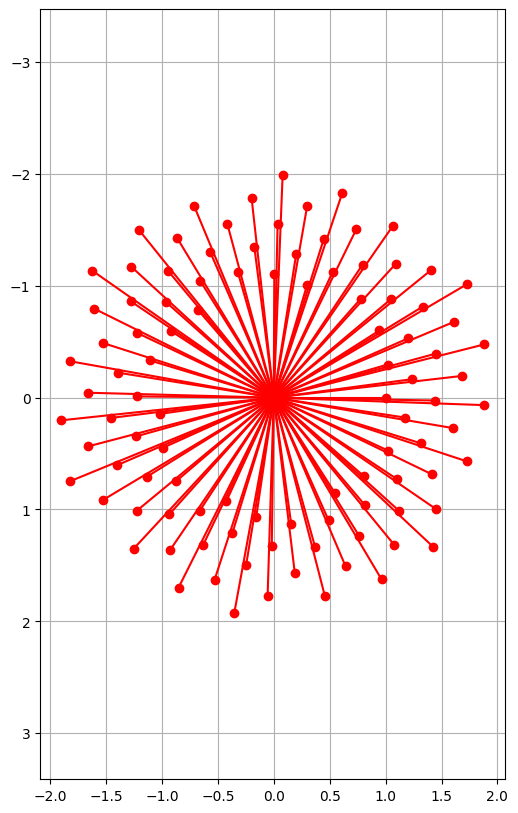

In [ ]:
# Plot the LIDAR measurements in a 2D space
plt.figure(figsize=(6, 10))
plt.plot([oy, np.zeros(np.size(oy))], [ox, np.zeros(np.size(oy))], "ro-")
plt.axis("equal")
bottom, top = plt.ylim()  # return the current ylim
plt.ylim((top, bottom))   # rescale y axis, to match the grid orientation
plt.grid(True)
plt.show()

In [ ]:
# Define the Bresenham line drawing algorithm
def bresenham(start, end):
    line = []
    x0, y0 = start
    x1, y1 = end
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = -1 if x0 > x1 else 1
    sy = -1 if y0 > y1 else 1
    err = dx - dy

    while x0 != x1 or y0 != y1:
        line.append((x0, y0))
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy

    line.append((x1, y1))
    return line


In [ ]:
# Initialize an occupancy grid map with unknown values (0.5)
def initialize_map(size_x, size_y):
    return np.full((size_x, size_y), 0.5)

In [ ]:
# Perform flood fill to fill empty areas in the occupancy grid map
def flood_fill(cpoint, pmap):
    sx, sy = pmap.shape
    fringe = deque()
    fringe.appendleft(cpoint)

    while fringe:
        n = fringe.pop()
        nx, ny = n

        # Check if the current cell is unoccupied (0.5)
        if pmap[nx, ny] == 0.5:
            pmap[nx, ny] = 0.0  # Fill the cell with zeros (free space)

            # Add neighboring cells to the fringe for further exploration
            if nx > 0:
                fringe.appendleft((nx - 1, ny))  # West
            if nx < sx - 1:
                fringe.appendleft((nx + 1, ny))  # East
            if ny > 0:
                fringe.appendleft((nx, ny - 1))  # North
            if ny < sy - 1:
                fringe.appendleft((nx, ny + 1))  # South


In [ ]:
# Generate the occupancy grid map from LIDAR data using ray casting
def generate_ray_casting_grid_map(ox, oy, xyreso, show_figure):
    minx = int(round(min(ox) / xyreso))
    maxx = int(round(max(ox) / xyreso))
    miny = int(round(min(oy) / xyreso))
    maxy = int(round(max(oy) / xyreso))
    xwidth = int(round(maxx - minx))
    ywidth = int(round(maxy - miny))
    pmap = initialize_map(xwidth + 1, ywidth + 1)

    for (x, y) in zip(ox, oy):
        ix = int(round(x / xyreso)) - minx
        iy = int(round(y / xyreso)) - miny
        pmap[ix, iy] = 1.0

    if show_figure:
        plt.figure(figsize=(20, 8))
        plt.subplot(122)
        plt.imshow(pmap, cmap="PiYG_r")
        plt.clim(-0.4, 1.4)
        plt.gca().set_xticks(np.arange(-.5, xwidth + 1, 1), minor=True)
        plt.gca().set_yticks(np.arange(-.5, ywidth + 1, 1), minor=True)
        plt.grid(True, which="minor", color="w", linewidth=0.6, alpha=0.5)
        plt.colorbar()
        plt.show()

    return pmap, minx, maxx, miny, maxy, xyreso


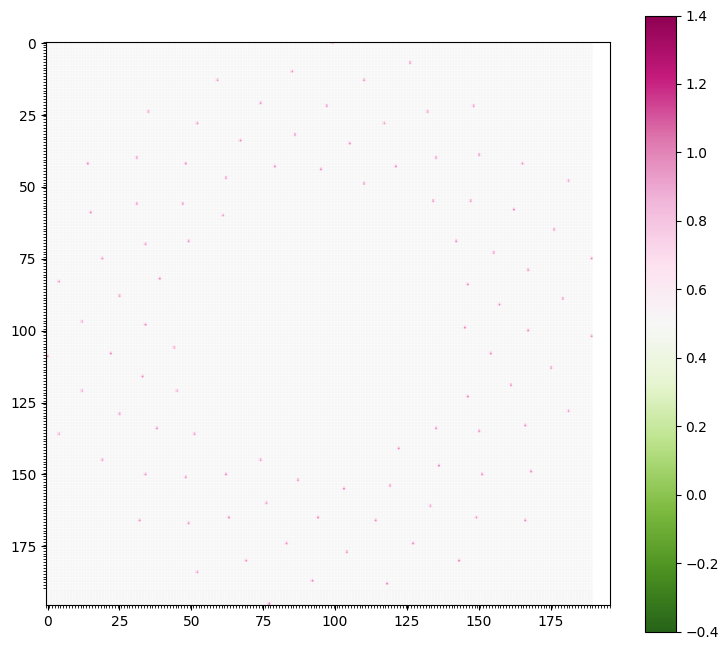

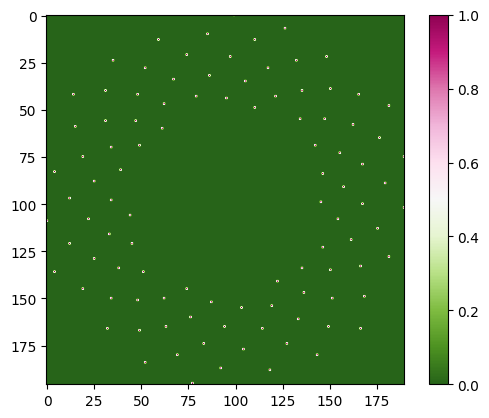

In [ ]:
# Perform the occupancy grid mapping on real LIDAR data
xyreso = 0.02  # x-y grid resolution
yawreso = math.radians(3.1)  # yaw angle resolution [rad]

# Generate the occupancy grid map from LIDAR data
pmap, minx, maxx, miny, maxy, xyreso = generate_ray_casting_grid_map(ox, oy, xyreso, True)

# Perform flood fill to fill empty areas in the occupancy grid map with zeros (free space)
flood_fill((10, 20), pmap)
map_float = np.array(pmap) / 10.0

# Display the occupancy grid map with colored representation
plt.imshow(pmap, cmap="PiYG_r")
plt.colorbar()
plt.show()
